# Web scraping to gain company insights on customer reviews

---

## Web scraping and analysis

We will use a package called `BeautifulSoup` to collect data from the web. Once we've collected the data and saved it into a local `.csv` file we will start analysing the data.

### Scraping data from Skytrax 

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the data on each of the individual review links.

In [10]:
# Import Python Libraries
import pandas as pd
from collections import Counter
# import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
import string
import nltk
from afinn import Afinn
from gensim import corpora
from gensim.models import LdaModel, LsiModel
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

## Create Function to scrape reviews

In [2]:
def scrape_airline_reviews(airline_name):
    try:
        # Define headers with a user-agent to mimic a web browser
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }

        # Base URL for the reviews
        base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"
        page_number = 1

        # Initialize an empty list to store all review data
        all_reviews = []

        # Initialize an empty list to store filtered text reviews
        customer_reviews = []


        # Scrape pages until there are no more next page links available
        while True:
            url = f"{base_url}{page_number}/"
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, "html.parser")

            # Extract review data from text_content
            text_reviews = soup.find_all('div', class_='text_content')

            # Filter out "Not Verified" and "Trip Verified" labels
            for review in text_reviews:

                # Concatenate the text content of children excluding tags
                review_text = review.get_text()
                if review_text and len(review_text.split("|")) > 1:
                  review_text = (review_text.split("|"))[1].strip()
                  customer_reviews.append(review_text)
                else:
                    customer_reviews.append(review_text)  

            # Extract review data from the table (adjust selectors as needed)
            tables = soup.find_all('table', class_='review-ratings')

            # Exclude tables enclosed in a div with class="ratings"
            tables = [table for table in tables if not table.find_parent("div", class_="ratings")]

            # Loop through each table and extract information
            for table in tables:
                data = {}
                for row in table.find_all('tr'):
                    cells = row.find_all('td')
                    if len(cells) == 2:
                        category = cells[0].text.strip()
                        value = cells[1].text.strip()
                        if 'stars' in cells[1].get('class', []):  # Check if the cell contains star ratings
                            stars = cells[1].find_all('span', class_='star fill')
                            rating = len(stars)
                            data[category] = rating
                        else:
                            data[category] = value
                all_reviews.append(data)

            # Check if there is a next page link
            next_page_link = soup.find("a", string=">>")
            if not next_page_link:
                break

            # Increment the page number for the next iteration
            page_number += 1


        # create a data frame
        df = pd.DataFrame(all_reviews)
        df["reviews"] = customer_reviews
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None



In [8]:
# Get reviews for selected airline
airline_name = "British Airways"
df = scrape_airline_reviews(airline_name)

In [12]:
# Create prefix for saving files using airline name initials
airline_name = "British Airways"
words = airline_name.split()
initials = ''.join([word[0] for word in words])
initials

'BA'

In [11]:
df.tail()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft,reviews
3790,NaN,Economy Class,NaN,NaN,3.0,1.0,2.0,0.0,NaN,NaN,3,no,NaN,This was a bmi Regional operated flight on a R...
3791,NaN,Business Class,NaN,NaN,4.0,5.0,4.0,0.0,NaN,NaN,3,yes,NaN,LHR to HAM. Purser addresses all club passenge...
3792,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,yes,NaN,My son who had worked for British Airways urge...
3793,NaN,Premium Economy,NaN,NaN,1.0,3.0,5.0,0.0,NaN,NaN,1,no,NaN,London City-New York JFK via Shannon on A318 b...
3794,NaN,First Class,NaN,NaN,4.0,5.0,5.0,2.0,NaN,NaN,2,no,NaN,SIN-LHR BA12 B747-436 First Class. Old aircraf...


In [112]:
# Save data to file
df.to_csv(f"data/{initials}_reviews.csv", index=False)

NameError: name 'df' is not defined

In [17]:
# Load the saved file for analysis
reviews_df = pd.read_csv(f"data/{initials}_reviews.csv")

In [18]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3795 entries, 0 to 3794
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type Of Traveller       3024 non-null   object 
 1   Seat Type               3793 non-null   object 
 2   Route                   3020 non-null   object 
 3   Date Flown              3017 non-null   object 
 4   Seat Comfort            3674 non-null   float64
 5   Cabin Staff Service     3662 non-null   float64
 6   Food & Beverages        3387 non-null   float64
 7   Inflight Entertainment  2610 non-null   float64
 8   Ground Service          2947 non-null   float64
 9   Wifi & Connectivity     646 non-null    float64
 10  Value For Money         3795 non-null   int64  
 11  Recommended             3795 non-null   object 
 12  Aircraft                1980 non-null   object 
 13  reviews                 3795 non-null   object 
dtypes: float64(6), int64(1), object(7)
memor

In [6]:
reviews_df.tail()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft,reviews
3790,NaN,Economy Class,NaN,NaN,3.0,1.0,2.0,0.0,NaN,NaN,3,no,NaN,This was a bmi Regional operated flight on a R...
3791,NaN,Business Class,NaN,NaN,4.0,5.0,4.0,0.0,NaN,NaN,3,yes,NaN,LHR to HAM. Purser addresses all club passenge...
3792,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,yes,NaN,My son who had worked for British Airways urge...
3793,NaN,Premium Economy,NaN,NaN,1.0,3.0,5.0,0.0,NaN,NaN,1,no,NaN,London City-New York JFK via Shannon on A318 b...
3794,NaN,First Class,NaN,NaN,4.0,5.0,5.0,2.0,NaN,NaN,2,no,NaN,SIN-LHR BA12 B747-436 First Class. Old aircraf...


In [7]:
text_reviews = pd.DataFrame(reviews_df['reviews'])

In [8]:
text_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3795 entries, 0 to 3794
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3795 non-null   object
dtypes: object(1)
memory usage: 29.8+ KB


In [9]:
text_reviews.tail()

,reviews
3790,This was a bmi Regional operated flight on a R...
3791,LHR to HAM. Purser addresses all club passenge...
3792,My son who had worked for British Airways urge...
3793,London City-New York JFK via Shannon on A318 b...
3794,SIN-LHR BA12 B747-436 First Class. Old aircraf...


## Data PreProcessing

#### Create helper functions

In [10]:
# Remove punctuations
string.punctuation

def remove_punctuation(text):
    punctuationfree="".join([char for char in text if char not in string.punctuation])
    return punctuationfree

# Tokenize text
def tokenize(text):
    tokens = text.split()
    return tokens

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [i for i in text if i not in stopwords]
    return tokens

# Lemmatize text
def lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_tokens


# We initialize Afinn sentiment analyzer
afinn = Afinn()

def check_sign(value):
    if value < 0:
        return "negative"
    elif value == 0:
        return "neutral"
    else:
        return "positive"

In [11]:
def clean_text(df):
    # Convert text to lower case
    df['clean_review'] = df['reviews'].str.lower()

    # Remove punctuation
    df['clean_review'] = df['clean_review'].apply(lambda x:remove_punctuation(x))

    # Tokenize text
    df['clean_review'] = df['clean_review'].apply(lambda x:tokenize(x))

    # Remove stopwords
    df['clean_review'] = df['clean_review'].apply(lambda x:remove_stopwords(x))

    #lemmatize text
    df['clean_review'] = df['clean_review'].apply(lambda x:lemmatize(x))

    # Get Sentiment Score
    df['sentiment_score'] = [afinn.score(review) for review in df['reviews']]
    
    # Split sentiment into positive, negative and neutral
    df['sentiment'] = df['sentiment_score'].apply(lambda x:check_sign(x))

    return df

In [12]:
text_reviews = clean_text(text_reviews)

In [13]:
text_reviews.head()

,reviews,clean_review,sentiment_score,sentiment
0,I flew from Malaga via LHR to Boston on the 4t...,"[flew, malaga, via, lhr, boston, 4th, may, 202...",-5.0,negative
1,Milan to Miami return via London. Worst busine...,"[milan, miami, return, via, london, worst, bus...",-7.0,negative
2,BA created a new low-cost subsidiary in BA Eur...,"[ba, created, new, lowcost, subsidiary, ba, eu...",12.0,positive
3,I flew with British Airways from Heathrow to H...,"[flew, british, airway, heathrow, hannover, al...",-7.0,negative
4,Manchester to Copenhagen via London on 30th Ap...,"[manchester, copenhagen, via, london, 30th, ap...",-4.0,negative


## Sentiments Analysis

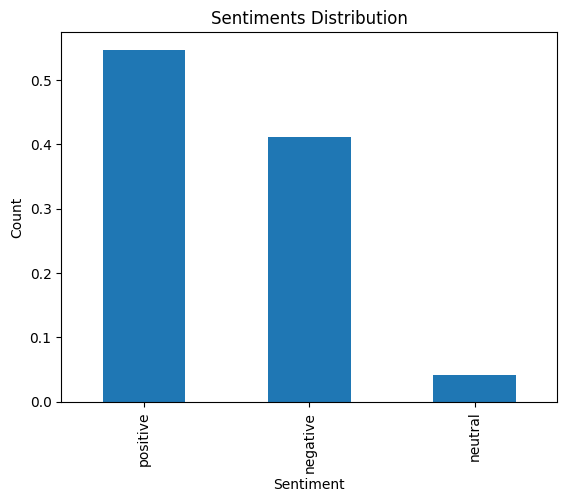

In [14]:
text_reviews['sentiment'].value_counts(normalize=True).sort_values(ascending=False).plot(kind='bar')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiments Distribution')

# Show plot
plt.show()

In [15]:
text_reviews['sentiment'].value_counts(normalize=True)

positive    0.546772
negative    0.411331
neutral     0.041897
Name: sentiment, dtype: float64

## Topic Modeling

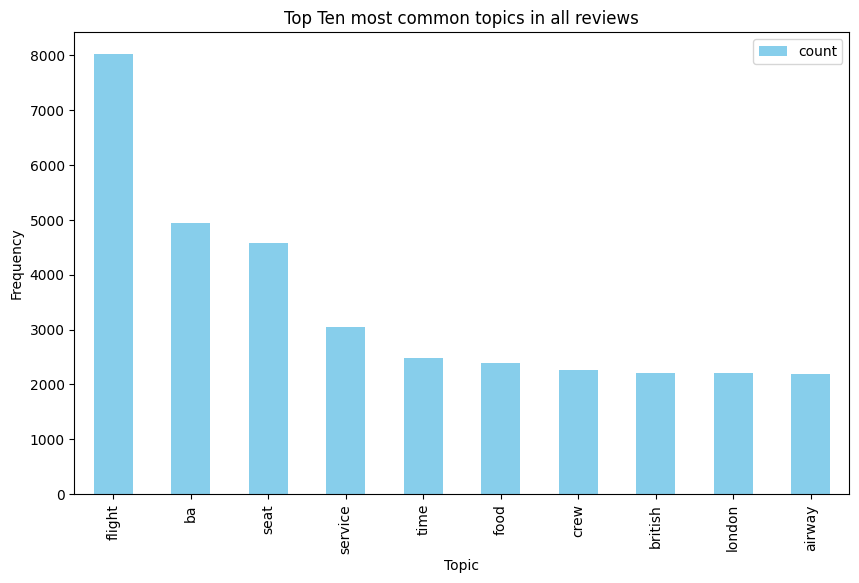

In [27]:
# Flatten the lists of words
all_words = [word for sublist in text_reviews['clean_review'] for word in sublist]

# Count the occurrences of each word
word_counts = Counter(all_words)

# Convert the word counts to a DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Sort the DataFrame by word counts in descending order
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Plot the word counts
word_counts_df.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Top Ten most common topics in all reviews')
plt.show()

In [28]:
# Create Corpus
corpus = text_reviews['clean_review'].tolist()

# Create document-term matrix
dictionary = corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

# Topic modeling using LDA Model
lda = LdaModel(doc_term_matrix, num_topics=3, id2word=dictionary)

# Topic modeling using LSA Model
lsa = LsiModel(doc_term_matrix, num_topics=3, id2word=dictionary)

In [29]:
# Results
print(lda.print_topics(num_topics=3, num_words=3))

[(0, '0.022*"flight" + 0.020*"seat" + 0.015*"ba"'), (1, '0.024*"flight" + 0.015*"ba" + 0.014*"seat"'), (2, '0.024*"flight" + 0.013*"ba" + 0.010*"good"')]


In [30]:
# Results
print(lsa.print_topics(num_topics=3, num_words=3))

[(0, '0.511*"flight" + 0.321*"ba" + 0.284*"seat"'), (1, '-0.557*"flight" + 0.527*"seat" + 0.233*"class"'), (2, '0.757*"ba" + -0.390*"seat" + -0.270*"flight"')]


## Create Word Cloud

In [31]:
text = " ".join(review for review in text_reviews['reviews'])
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 3370746 words in the combination of all reviews.


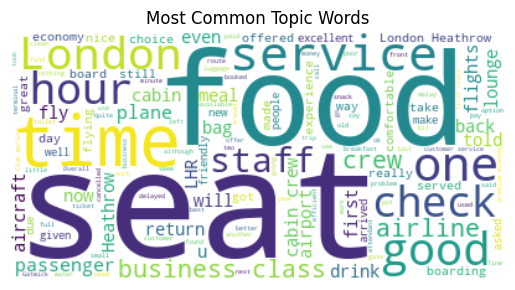

In [32]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["flew", "british", "ba", "airway", "via", "airways", "flight"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Topic Words")
plt.show()

In [33]:
# Save the image in the img folder:
wordcloud.to_file("data/world_cloud.png")